In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from tqdm import tqdm
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from catboost import CatBoostRegressor
import optuna 
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import warnings
from scipy.signal import savgol_filter

%matplotlib inline

In [3]:
np.random.seed(1)
    
   
torch.manual_seed(1)
torch.cuda.manual_seed(1)

In [4]:
FILE_WAY = '/kaggle/input/nasa-battery-dataset/cleaned_dataset' 
metadata = pd.read_csv(f'{FILE_WAY}/metadata.csv')
metadata.head()  # Capacity ~ SOH

,type,start_time,ambient_temperature,battery_id,test_id,uid,filename,Capacity,Re,Rct
0,discharge,[2010. 7. 21. 15. 0. ...,4,B0047,0,1,00001.csv,1.6743047446975208,NaN,NaN
1,impedance,[2010. 7. 21. 16. 53. ...,24,B0047,1,2,00002.csv,NaN,0.05605783343888099,0.20097016584458333
2,charge,[2010. 7. 21. 17. 25. ...,4,B0047,2,3,00003.csv,NaN,NaN,NaN
3,impedance,[2010 7 21 20 31 5],24,B0047,3,4,00004.csv,NaN,0.05319185850921101,0.16473399914864734
4,discharge,[2.0100e+03 7.0000e+00 2.1000e+01 2.1000e+01 2...,4,B0047,4,5,00005.csv,1.5243662105099023,NaN,NaN


In [5]:
class Battery:
    """NASA battery data loader and processor."""
    
    def __init__(self, bat_id, to_sort = False, tensor = False, 
                 crop = None, drop_time = False):
        """
        Args:
            bat_id: Battery ID from metadata
            to_sort: Sort capacity values if True
            tensor: Convert to PyTorch tensors if True  
            crop: Crop cycles to this length
            drop_time: Remove Time column if True
        """
        self.tensor = tensor
        self.bat_id = bat_id
        mask = (metadata['battery_id'] == self.bat_id) & (metadata['type'] == 'discharge')
        self.capacity =  metadata.loc[mask].copy()
        self.capacity.loc[:, 'Capacity'] = pd.to_numeric(self.capacity['Capacity']) / 2.0 # init capacity
        if to_sort:
            self.capacity = self.capacity.sort_values('Capacity')
        self.y = np.array(self.capacity['Capacity'], dtype=float)
        if tensor:
            self.y = torch.tensor(self.y, dtype=torch.float32)
        self._get_data(crop=crop, drop_time=drop_time)
        
        
    def _get_data(self, crop=None, drop_time=False):
        self.data = []
        self.table = []
        if crop is None:
            crop = float('inf')
            for file in self.capacity['filename']:
                table = pd.read_csv(f'{FILE_WAY}/data/{file}')
                crop = min(crop, table.shape[0]) # select min shape 
                
        for file in self.capacity['filename']:
            table = pd.read_csv(f'{FILE_WAY}/data/{file}')
            if drop_time:
                table = table.drop(columns=['Time'])

            self.table.append(np.array(table)[:crop])
        self.table = np.array(self.table)
        if self.tensor:
            self.table = torch.tensor(self.table, dtype=torch.float32)
            
    def __str__(self):
        return f"Battery_{int(self.bat_id[-2:])}"
        

def results(y_test: np.ndarray, y_pred: np.ndarray, ax: plt.Axes = None, 
           label: str = '') -> dict:
    """
    Plot and calculate metrics for SOH predictions.
    
    Returns:
        dict with r2, rmse, mae metrics
    """
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    print(f'R2 score = {r2:.3f}')
    print(f'rmse = {100 * rmse:.3f}%')
    print(f'mae = {mae:.3f}')
    if ax is None:
        fig, ax = plt.subplots(figsize=(15,15))
    cycles = np.arange(1, len(y_test) + 1)
    ax.plot(cycles, y_test, color='red', label='Test SOH')
    ax.plot(cycles, y_pred, color='green', label='Predicted SOH')
    ax.set_xlabel('Cycle', fontsize=20)
    ax.set_ylabel('SOH', fontsize=20)
    ax.set_title(label, fontsize=20)
    plt.grid()
    ax.legend(fontsize=15)
    return {'r2': r2, 'rmse': rmse, 'mae': mae}




In [6]:
# train on bat5 and bat6, val on bat18, test on bat7

bat7 = Battery('B0007', tensor=True, drop_time=True)
X_test_torch = bat7.table
y_test_torch = bat7.y
crop = X_test_torch.shape[1]

bat5 = Battery('B0005', tensor=True, drop_time=True)
bat6 = Battery('B0006', tensor=True, drop_time=True)

X_train_torch = torch.cat([bat5.table, bat6.table], dim=0)
y_train_torch = torch.cat([bat5.y, bat6.y], dim=-1)

bat18 = Battery('B0018', tensor=True, drop_time=True)
X_val_torch = bat18.table
y_val_torch = bat18.y



tr_dataset = TensorDataset(X_train_torch, y_train_torch)

val_dataset = TensorDataset(X_val_torch, y_val_torch)


tr_dataloader = DataLoader(tr_dataset,
                           batch_size=32, shuffle=True)  

val_dataloader = DataLoader(val_dataset, batch_size=16)



for i in tr_dataloader:
    print(i[0].shape)
    break

torch.Size([32, 179, 5])


In [7]:
bat7 = Battery('B0007')
X_test_np = bat7.table
crop = X_test_np.shape[1]
X_test_np = X_test_np.reshape(X_test_np.shape[0], -1)
y_test_np = bat7.y

bat5 = Battery('B0005', crop=crop)
bat6 = Battery('B0006', crop=crop)

X_train_np = np.concatenate([bat5.table, bat6.table], 0)
X_train_np = X_train_np.reshape(X_train_np.shape[0], -1)
y_train_np = np.concatenate([bat5.y, bat6.y], -1)

bat18 = Battery('B0018', crop=crop)
X_val_np = bat18.table
X_val_np = X_val_np.reshape(X_val_np.shape[0], -1)
y_val_np = bat18.y



tr_dataset_fl = TensorDataset(torch.tensor(X_train_np, dtype=torch.float32), y_train_torch)

val_dataset_fl = TensorDataset(torch.tensor(X_val_np, dtype=torch.float32), y_val_torch)

tr_dataloader = DataLoader(tr_dataset,
                           batch_size=32, shuffle=True)  


tr_dataloader_fl = DataLoader(tr_dataset_fl,
                           batch_size=32, shuffle=True)  

val_dataloader_fl = DataLoader(val_dataset_fl, batch_size=16)

X_train_np.shape, X_val_np.shape, X_test_np.shape
# y_train_np.shape

((336, 1074), (132, 1074), (168, 1074))

In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [9]:
pd.read_csv(f'{FILE_WAY}/data/00001.csv')

,Voltage_measured,Current_measured,Temperature_measured,Current_load,Voltage_load,Time
0,4.246711,0.000252,6.212696,0.0002,0.000,0.000
1,4.246764,-0.001411,6.234019,0.0002,4.262,9.360
2,4.039277,-0.995093,6.250255,1.0000,3.465,23.281
3,4.019506,-0.996731,6.302176,1.0000,3.451,36.406
4,4.004763,-0.992845,6.361645,1.0000,3.438,49.625
...,...,...,...,...,...,...
485,3.303251,-0.001760,9.662331,0.0004,0.000,6382.063
486,3.310303,-0.000756,9.390489,0.0002,0.000,6395.547
487,3.317351,-0.003318,9.137008,0.0002,0.000,6409.063
488,3.323387,-0.002291,8.972806,0.0002,0.000,6422.625


In [10]:
def extract_ica_features(X, min_volt=2.4, max_volt=4.2):
    n_samples = X.shape[0]
    features = []

    for i in range(n_samples):
        voltage = X[i, :, 0]  
        current = X[i, :, 1]  
        time = X[i, :, -1]  



        # filter by cut_off voltage
        mask = (voltage >= min_volt) & (voltage <= max_volt)
        voltage = voltage[mask]
        current = current[mask]
        time = time[mask]
        
        dt = np.diff(time, prepend=time[0]) / 3600  

        Q = np.cumsum(np.abs(current) * dt)

        dQ = np.gradient(Q)
        dV = np.gradient(voltage)
        dQ_dV = dQ / dV

        dQ_dV_smooth = savgol_filter(dQ_dV, window_length=15, polyorder=2)

        peak_height = np.min(dQ_dV_smooth)
        peak_idx = np.argmin(dQ_dV_smooth)
        peak_voltage = voltage[peak_idx]  
        area_under_curve = np.trapz(dQ_dV_smooth, voltage)

        features.append([peak_height, peak_voltage, area_under_curve])
        
    return dQ_dV_smooth, voltage, np.array(features)

min_voltages = {5: 2.7, 6: 2.7, 7: 2.2, 18: 2.5}

dqdv_train, v_tr, ica_train = extract_ica_features(np.concatenate([bat5.table, bat6.table], 0), min_volt=2.7)
dqdv_val, v_val, ica_val = extract_ica_features(bat18.table, min_volt=2.2)
dqdv_test, v_test, ica_test = extract_ica_features(bat7.table, min_volt=2.5)



In [12]:
X_train_ica_np = np.concatenate([X_train_np, ica_train], 1)
X_val_ica_np = np.concatenate([X_val_np, ica_val], 1)
X_test_ica_np = np.concatenate([X_test_np, ica_test], 1)

X_train_torch.shape, ica_train.shape
tr_ds = TensorDataset(X_train_torch, torch.tensor(ica_train, dtype=torch.float32), y_train_torch)
val_ds = TensorDataset(X_val_torch, torch.tensor(ica_val, dtype=torch.float32), y_val_torch)

tr_dl_ica = DataLoader(tr_ds, batch_size=32, shuffle=True)
val_dl_ica = DataLoader(tr_ds, batch_size=16)

In [ ]:
# try catboost with optuna.
def objective_catboost(trial, X_train, y_train, X_val, y_val):
    params = {
        'iterations': trial.suggest_int('iterations', 500, 2000),
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.1, log=True),
        'depth': trial.suggest_int('depth', 4, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10, log=True),
        'random_strength': trial.suggest_float('random_strength', 0.1, 10, log=True),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0),
        'leaf_estimation_iterations': trial.suggest_int('leaf_estimation_iterations', 1, 15),
        'verbose': False, 
        'random_seed': 1488,
        'loss_function': 'RMSE',  
        'task_type': 'GPU',  
        # uncomment if cuda is available 
    }
   
    
    model = CatBoostRegressor(**params)
    model.fit(
        X_train, y_train,
        eval_set=(X_val, y_val),
        early_stopping_rounds=50,
        verbose=False
    )
    
    y_val_pred = model.predict(X_val)
    mse = mean_squared_error(y_val, y_val_pred)

    return np.sqrt(mse)

In [128]:
class LSTM(nn.Module):
    """
    Simple LSTM regressor.

    Args:
        in_size: input feature size
        out_size: output size
        hid_size: hidden size of LSTM
        large_nn: if True, use deep head
        dropout: dropout in LSTM
        num_layers: number of LSTM layers
    """
    def __init__(self,
                 in_size=5, out_size=1, hid_size=100, 
                 large_nn=True, dropout=0, num_layers=2):
    
        super().__init__()
        self.lstm = nn.LSTM(in_size, hid_size, batch_first=True,
                            dropout=dropout, num_layers=num_layers)
        if large_nn:
            self.nn = nn.Sequential(
                nn.Linear(hid_size, hid_size // 2),
                nn.LayerNorm(hid_size // 2), 
                nn.ReLU(),
                nn.Linear(hid_size // 2, hid_size // 4),
                nn.LayerNorm(hid_size // 4),
                nn.ReLU(),
                nn.Linear(hid_size // 4, out_size)
            )
        else:
            self.nn = nn.Linear(hid_size, out_size)

    def forward(self, x):
        """
        Forward pass.

        Args:
            x: (batch, seq_len, in_size)

        Returns:
            (batch, out_size)
        """
        out, (h_n, c_n) = self.lstm(x)
        return self.nn(h_n[-1])


def train(model, tr_load, test_load, optim=None, crit=None, 
          n_epochs=30, prog=False, sched=False):
    """
    Train model and validate.

    Args:
        model: LSTM model
        tr_load: train dataloader
        test_load: test dataloader
        optim: optimizer
        crit: loss function
        n_epochs: number of epochs
        prog: disable progress bar
        sched: lr scheduler usage (if False - not use)

    Returns:
        train_losses, test_losses, best_model
    """
    model.to(device)
    if optim is None:
        optim = torch.optim.AdamW(model.parameters(), lr=1e-3) 
    if crit is None:
        crit = nn.MSELoss()  
    
    scheduler = None
    if sched:
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optim, mode='min', factor=0.5, patience=5, verbose=True, min_lr=1e-6
        )
        
    train_losses = np.zeros(n_epochs)
    test_losses = np.zeros(n_epochs)
    best_loss = float('inf')
    best_model = None
    
    for ep in tqdm(range(n_epochs), disable=prog):
        # Training
        model.train()
        tr_loss = 0
        for X, y in tr_load:
            X, y = X.to(device), y.to(device)  
            optim.zero_grad()  
            output = model(X).squeeze()  
            loss = crit(output, y) 
            loss.backward() 
            # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  
            optim.step() 
            tr_loss += loss.item()  
            
        train_losses[ep] = np.sqrt(tr_loss / len(tr_load)) 

        model.eval()
        test_loss = 0
        with torch.no_grad():
            for X, y in test_load:
                X, y = X.to(device), y.to(device)
                output = model(X).squeeze()
                loss = crit(output, y)
                test_loss += loss.item()
                
        test_losses[ep] = np.sqrt(test_loss / len(test_load))  
        
        if test_losses[ep] < best_loss:
            best_model = model
            
        if scheduler:
            scheduler.step(test_losses[ep])
    
    return train_losses, test_losses, best_model

In [ ]:
class LSTM_ica(nn.Module):
    """
    LSTM model with extra ICA input.
    Combines LSTM hidden state with ICA embedding.
    """
    def __init__(self,
                 in_size=5, out_size=1, hid_size=100, 
                 large_nn=True, dropout=0, num_layers=2, ica_size=3):
        super().__init__()
        self.lstm = nn.LSTM(in_size, hid_size, batch_first=True,
                            dropout=dropout, num_layers=num_layers)

        self.mlp_ica = nn.Sequential(
            nn.Linear(ica_size, hid_size // 2),
            nn.ReLU(),
            nn.Linear(hid_size // 2, hid_size)
        )
        
        self.fc_combined = nn.Sequential(
            nn.Linear(hid_size * 2, hid_size),
            nn.ReLU(),
            nn.Linear(hid_size, out_size)
        )
        
        if large_nn:
            self.nn = nn.Sequential(
                nn.Linear(hid_size, hid_size // 2),
                nn.LayerNorm(hid_size // 2), 
                nn.ReLU(),
                nn.Linear(hid_size // 2, hid_size // 4),
                nn.LayerNorm(hid_size // 4),
                nn.ReLU(),
                nn.Linear(hid_size // 4, out_size)
            )
        else:
            self.nn = nn.Linear(hid_size + ica_size, 1)
                                    
    def forward(self, ts_x, ica_x):
        """
        Forward pass.  
        ts_x: time-series input  
        ica_x: ICA features  
        """
        out, (h_n, c_n) = self.lstm(ts_x)
        lstm_hidden = h_n[-1]  

        ica_embedding = self.mlp_ica(ica_x) 
        combined = torch.cat((lstm_hidden, ica_embedding), dim=1)  
        output = self.fc_combined(combined)  
        return output.squeeze(-1) 


def train_ica(model, tr_load, test_load, optim=None,
              crit=None, n_epochs=30, 
              sched=False, prog=False):
    """
    Train loop for LSTM_ica.  
    parameters: 
        tr_load, test_load: dataloaders with (X, ICA, y)  
        optim: optimizer (default - AdamW)
        n_epochs: number epochs for learn
        crit: loss criteria (default - MSE)
        sched: scheduler usage (default - off, default scheduler - ReduceLROnPlateau)
        prog: usage progress bar (default - on)
    """
    model.to(device)
    if optim is None:
        optim = torch.optim.AdamW(model.parameters(), lr=3e-5)  
    if crit is None:
        crit = nn.MSELoss()  
    if sched is True:
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optim, mode='min', factor=0.5, patience=5, verbose=True, min_lr=1e-6)
        
    train_losses = np.zeros(n_epochs)
    test_losses = np.zeros(n_epochs)
    
    for ep in tqdm(range(n_epochs), disable=prog):
        model.train()
        tr_loss = 0
        for X, ica, y in tr_load:
            X, ica, y = X.to(device), ica.to(device), y.to(device)  
            optim.zero_grad()  
            output = model(X, ica).squeeze()  
            loss = crit(output, y) 
            loss.backward() 
            optim.step() 
            tr_loss += np.sqrt(loss.item())
        train_losses[ep] = tr_loss / len(tr_load)

        model.eval()
        test_loss = 0
        with torch.no_grad():
            for X, ica, y in test_load:
                X, ica, y = X.to(device), ica.to(device), y.to(device)
                y = y.unsqueeze(-1) 
                output = model(X, ica).squeeze()
                loss = crit(output, y)
                test_loss += np.sqrt(loss.item())
        test_losses[ep] = test_loss / len(test_load)
        if sched:
            scheduler.step(test_loss / len(test_load))
    
    return train_losses, test_losses


In [117]:
def study_res(train, test, crop=0, ax=None):
    """
    Plot train/test loss curves.
    crop: skip first epochs
    ax: optional matplotlib axis
    """
    train = train[crop:]
    test = test[crop:]
    if ax is None:
        fig, ax = plt.subplots()
    ax.plot(train, label='Train Loss', color='blue')
    ax.plot(test, label='Test Loss', color='red')
    ax.set_title('Study results')
    ax.set_xlabel('Epoch', fontsize=20)
    ax.set_ylabel('RMSE', fontsize=20)
    plt.grid()


def test_model(model, n_ep, optim=None, label='', tr_dl=tr_dataloader,
               val_dl=val_dataloader, X_tst=X_test_torch, sched=False, ica=False):
    """
    Train and evaluate model.
    model: LSTM or LSTM_ica
    n_ep: number of epochs
    ica: if True, use ICA training/eval
    """
    if not ica:
        train_losses, test_losses, best_model = train(model, tr_dl,
                                          val_dl, n_epochs=n_ep, optim=optim, sched=sched)
    else:
        train_losses, test_losses = train_ica(model, tr_dl,
                                              val_dl, n_epochs=n_ep, optim=optim, sched=sched)
        
    model.eval()
    if not ica:
        pred = model(X_tst.to(device))
        pred_best = best_model(X_tst.to(device))
    else:
        pred = model(X_tst.to(device), torch.tensor(ica_test, dtype=torch.float32).to(device))
    
    fig, axes = plt.subplots(1, 2, figsize=(20, 10))
    fig.suptitle(label, fontsize=16)
    
    results(y_test_torch, pred.cpu().detach().numpy(), ax=axes[0])
    axes[0].set_title('Prediction Results final model')

    
    study_res(train_losses, test_losses, crop=20, ax=axes[1])
    axes[1].set_title('Training History')
    plt.legend(fontsize=15)


    plt.show()


In [25]:
# just use optuna 

def objective_lstm(trial, tr_dl, val_dl):
    num_layers = trial.suggest_int('num_layers', 1, 10)
    hidden_size = trial.suggest_int('hidden_size', 15, 500)
    dropout = trial.suggest_float('dropout', 0.0, 0.3) 


    model = LSTM(hid_size=hidden_size, num_layers=num_layers,
                 dropout=dropout)
    
    # optim = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=0.01)
    crit = nn.MSELoss()
    train_losses, val_losses = train(model, tr_dl, val_dl, n_epochs=100)
    val_loss = val_losses[:30].mean()

    return np.sqrt(val_loss)



study_lstm = optuna.create_study(
    direction='minimize'
)



study_lstm.optimize(lambda trial: objective_lstm(trial, tr_dataloader, val_dataloader), 
                        n_trials=30, show_progress_bar=True)

[I 2025-09-23 13:09:16,700] A new study created in memory with name: no-name-e9b9c114-4614-4207-a539-9afad2f93f44


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2025-09-23 13:11:36,866] Trial 0 finished with value: 0.2700549622338361 and parameters: {'num_layers': 8, 'hidden_size': 251, 'dropout': 0.0020127912981962592}. Best is trial 0 with value: 0.2700549622338361.
[I 2025-09-23 13:12:08,678] Trial 1 finished with value: 0.241702029225069 and parameters: {'num_layers': 2, 'hidden_size': 246, 'dropout': 0.07569426967234827}. Best is trial 1 with value: 0.241702029225069.
[I 2025-09-23 13:12:13,391] Trial 2 finished with value: 0.2593583248063526 and parameters: {'num_layers': 2, 'hidden_size': 53, 'dropout': 0.0698649254401199}. Best is trial 1 with value: 0.241702029225069.


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.19439333797278716 and num_layers=1
  warnings.warn(


[I 2025-09-23 13:12:17,409] Trial 3 finished with value: 0.29471298899257753 and parameters: {'num_layers': 1, 'hidden_size': 82, 'dropout': 0.19439333797278716}. Best is trial 1 with value: 0.241702029225069.
[I 2025-09-23 13:14:48,719] Trial 4 finished with value: 0.26224089420837826 and parameters: {'num_layers': 6, 'hidden_size': 443, 'dropout': 0.27097119636551076}. Best is trial 1 with value: 0.241702029225069.
[I 2025-09-23 13:14:55,126] Trial 5 finished with value: 0.25045351158343526 and parameters: {'num_layers': 3, 'hidden_size': 87, 'dropout': 0.23654428639811018}. Best is trial 1 with value: 0.241702029225069.
[I 2025-09-23 13:15:05,469] Trial 6 finished with value: 0.24833553109640852 and parameters: {'num_layers': 6, 'hidden_size': 65, 'dropout': 0.07794993959473921}. Best is trial 1 with value: 0.241702029225069.
[I 2025-09-23 13:17:36,751] Trial 7 finished with value: 0.27037196414679954 and parameters: {'num_layers': 7, 'hidden_size': 371, 'dropout': 0.258367037366996

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.18943213825395563 and num_layers=1
  warnings.warn(


[I 2025-09-23 13:28:52,606] Trial 14 finished with value: 0.5455614513647504 and parameters: {'num_layers': 1, 'hidden_size': 17, 'dropout': 0.18943213825395563}. Best is trial 1 with value: 0.241702029225069.
[I 2025-09-23 13:33:16,087] Trial 15 finished with value: 0.2757807821758783 and parameters: {'num_layers': 10, 'hidden_size': 499, 'dropout': 0.10006055702381451}. Best is trial 1 with value: 0.241702029225069.
[I 2025-09-23 13:34:44,244] Trial 16 finished with value: 0.25544700250815355 and parameters: {'num_layers': 6, 'hidden_size': 137, 'dropout': 0.0329353864971412}. Best is trial 1 with value: 0.241702029225069.
[I 2025-09-23 13:35:49,007] Trial 17 finished with value: 0.26209212116726677 and parameters: {'num_layers': 4, 'hidden_size': 237, 'dropout': 0.178737675460716}. Best is trial 1 with value: 0.241702029225069.
[I 2025-09-23 13:38:30,124] Trial 18 finished with value: 0.27547993958878986 and parameters: {'num_layers': 8, 'hidden_size': 352, 'dropout': 0.041459497321

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.16820537554220372 and num_layers=1
  warnings.warn(


[I 2025-09-23 13:41:17,299] Trial 25 finished with value: 0.25163377514519114 and parameters: {'num_layers': 1, 'hidden_size': 168, 'dropout': 0.16820537554220372}. Best is trial 1 with value: 0.241702029225069.
[I 2025-09-23 13:41:24,785] Trial 26 finished with value: 0.34638590127698443 and parameters: {'num_layers': 5, 'hidden_size': 63, 'dropout': 0.08088977911484191}. Best is trial 1 with value: 0.241702029225069.
[I 2025-09-23 13:42:21,718] Trial 27 finished with value: 0.24322283218281773 and parameters: {'num_layers': 3, 'hidden_size': 293, 'dropout': 0.1265768970269859}. Best is trial 1 with value: 0.241702029225069.
[I 2025-09-23 13:43:18,369] Trial 28 finished with value: 0.2584232022266309 and parameters: {'num_layers': 3, 'hidden_size': 291, 'dropout': 0.21375992826325646}. Best is trial 1 with value: 0.241702029225069.
[I 2025-09-23 13:43:51,909] Trial 29 finished with value: 0.25379809263576053 and parameters: {'num_layers': 2, 'hidden_size': 247, 'dropout': 0.1299598808

{'num_layers': 2, 'hidden_size': 246, 'dropout': 0.07569426967234827}


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([16, 1])) that is different to the input size (torch.Size([16])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R2 score = 0.972055
rmse = 1.274499%
mae = 0.008982


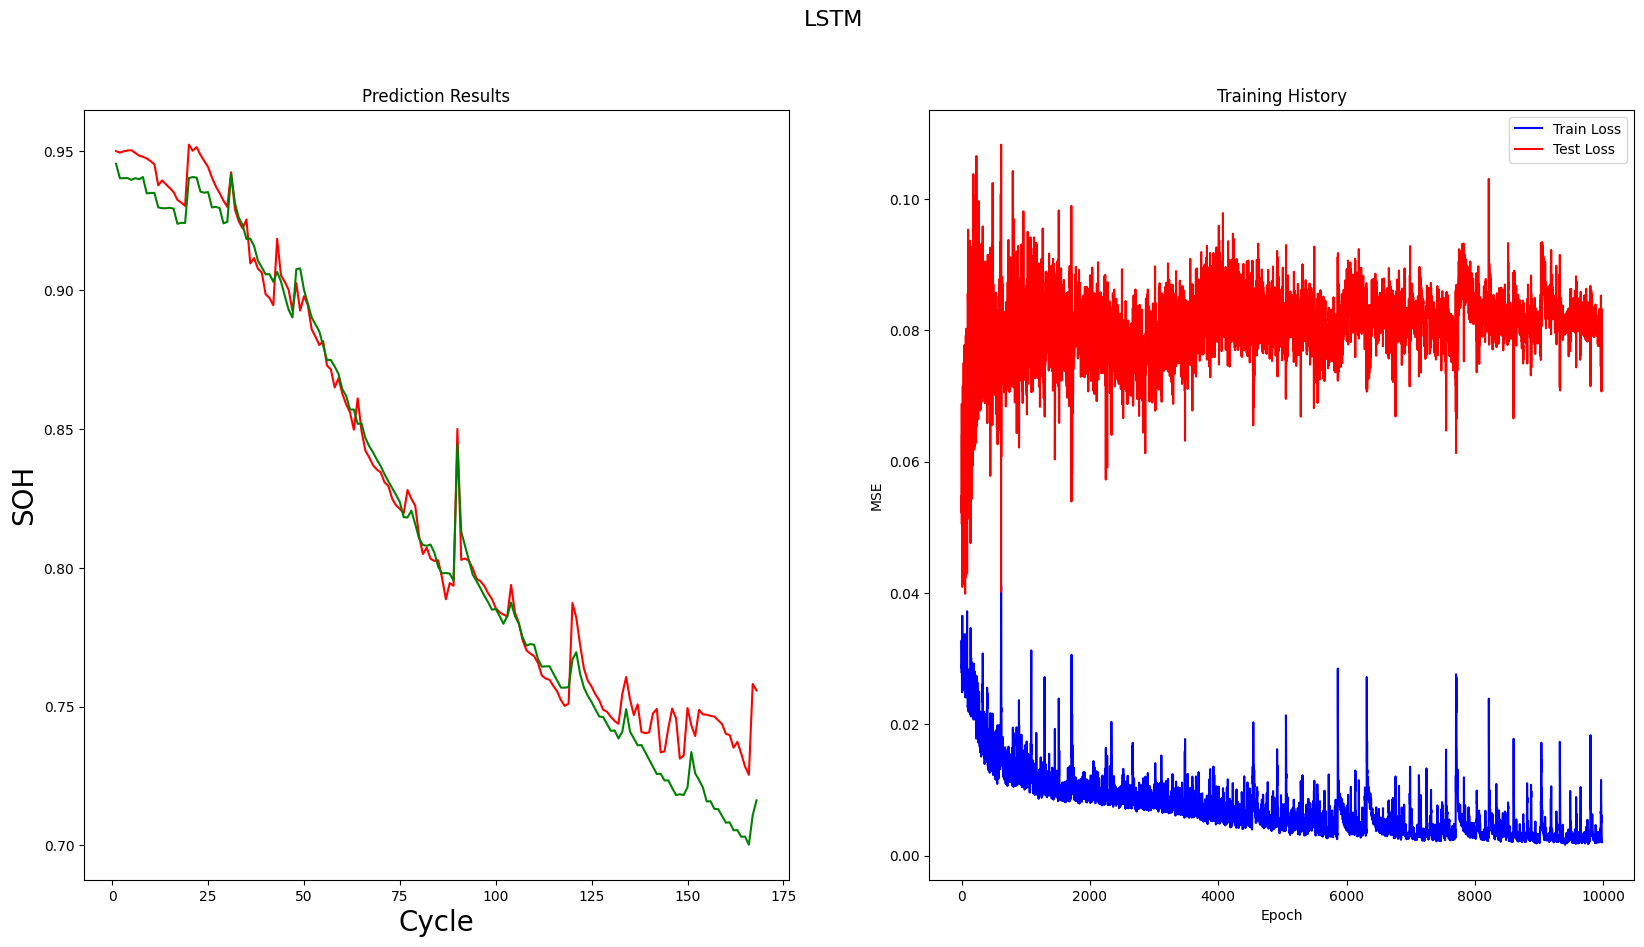

In [37]:
d = study_lstm.best_params
print(d)
best_lstm = LSTM(hid_size = d['hidden_size'], num_layers=d['num_layers'], dropout=d['dropout'])
test_lstm_model(best_lstm, 10000, label='LSTM')

In [15]:
# torch.save(best_lstm, '/kaggle/working/best_lstm.md')
best_lstm = torch.load('/kaggle/input/best_lstm/pytorch/default/1/best_lstm.md', 
                        weights_only=False)

In [51]:
# now try use lstm as feature extractor, then train catboost

new_features_train = best_lstm.lstm(X_train_torch.to(device))[1][0][-1]
new_features_val = best_lstm.lstm(X_val_torch.to(device))[1][0][-1]
new_features_test = best_lstm.lstm(X_test_torch.to(device))[1][0][-1]


study_new_feat = optuna.create_study(
    direction='minimize'
)

study_new_feat.optimize(lambda trial: objective_catboost(trial, 
                                                         new_features_train.detach().cpu().numpy(), 
                                                         y_train_np,
                                                         new_features_val.detach().cpu().numpy(), 
                                                         y_val_np), 
                        n_trials=30, show_progress_bar=True)



[I 2025-09-23 15:08:54,475] A new study created in memory with name: no-name-6bd2c705-c1dd-457d-bcea-cd0162670fe6


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2025-09-23 15:09:09,672] Trial 0 finished with value: 0.04812731995022575 and parameters: {'iterations': 823, 'learning_rate': 0.08441865479938183, 'depth': 9, 'l2_leaf_reg': 1.3918012843377152, 'random_strength': 3.4925785311022834, 'bagging_temperature': 0.2479752016907123, 'leaf_estimation_iterations': 9}. Best is trial 0 with value: 0.04812731995022575.
[I 2025-09-23 15:10:16,026] Trial 1 finished with value: 0.04854473408425052 and parameters: {'iterations': 908, 'learning_rate': 0.00692457365074121, 'depth': 9, 'l2_leaf_reg': 8.031875762023502, 'random_strength': 5.3330737065002936, 'bagging_temperature': 0.12504642206019811, 'leaf_estimation_iterations': 12}. Best is trial 0 with value: 0.04812731995022575.
[I 2025-09-23 15:10:21,225] Trial 2 finished with value: 0.04117430321278422 and parameters: {'iterations': 1670, 'learning_rate': 0.06973037052655735, 'depth': 7, 'l2_leaf_reg': 1.3311184618123917, 'random_strength': 0.12687781171218535, 'bagging_temperature': 0.800175001

{'iterations': 515, 'learning_rate': 0.022579407123406805, 'depth': 4, 'l2_leaf_reg': 5.940835016821127, 'random_strength': 0.11280337390450483, 'bagging_temperature': 0.46690009543570943, 'leaf_estimation_iterations': 6}
R2 score = 0.824239
rmse = 3.363769%
mae = 0.027858


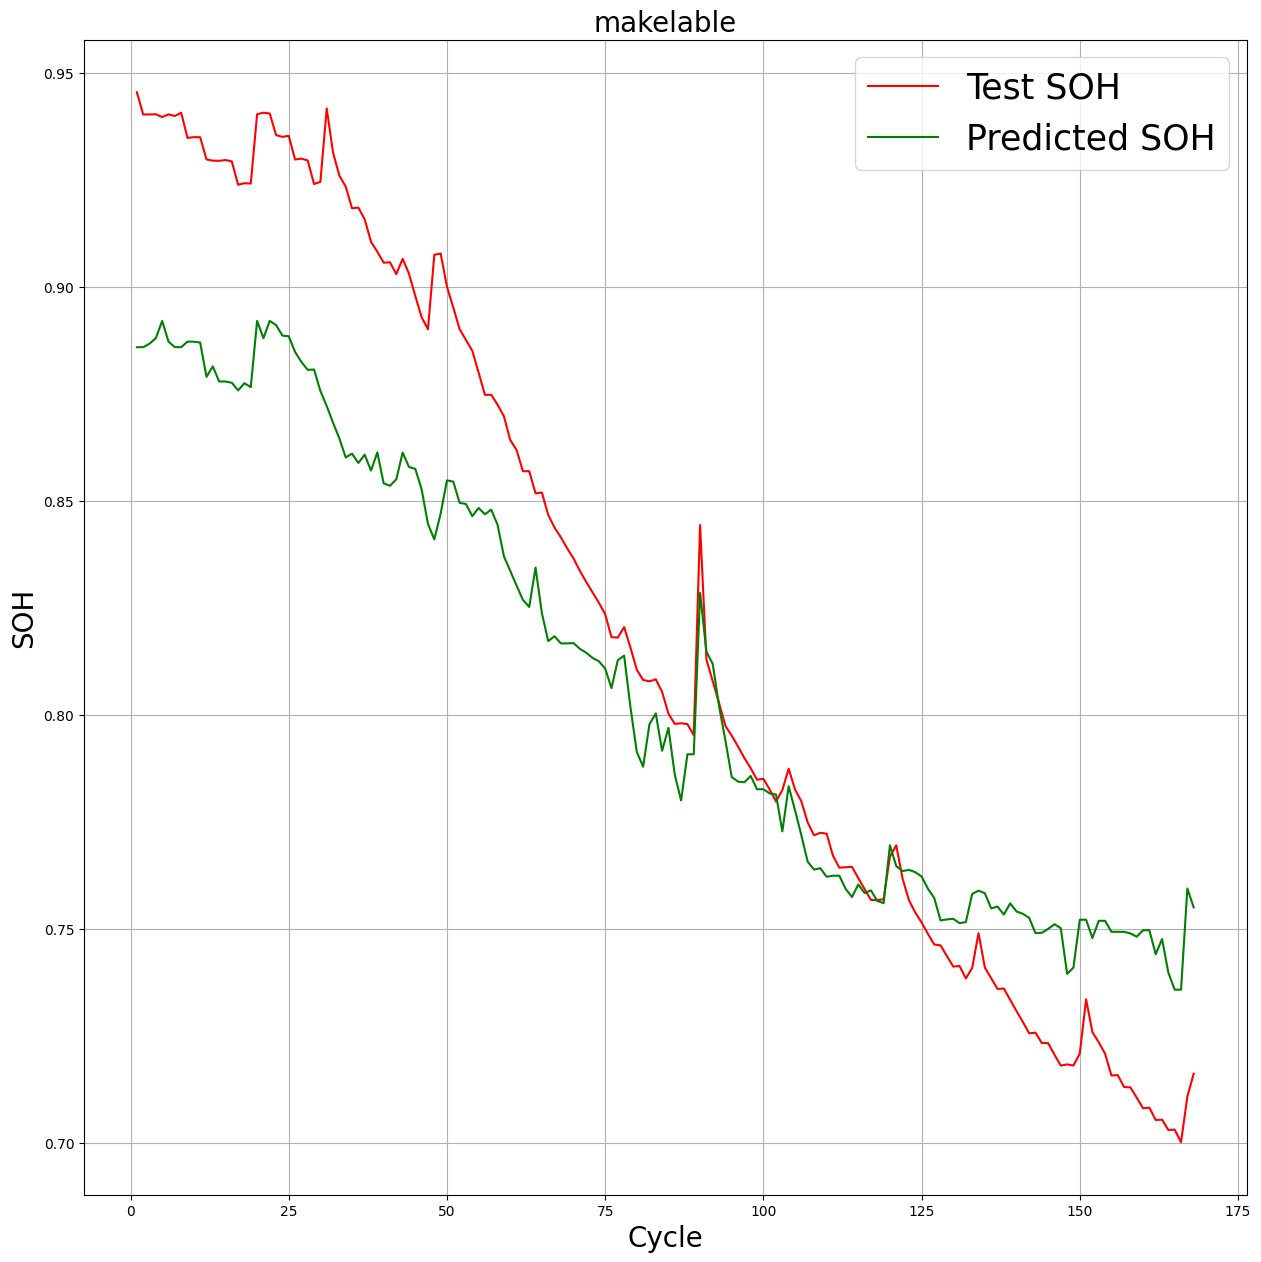

In [54]:
print(study_new_feat.best_params)
new_feat_best = CatBoostRegressor(**study_new_feat.best_params)
new_feat_best.fit(
    new_features_train.detach().cpu().numpy(), y_train_np,
    eval_set=(new_features_val.detach().cpu().numpy(), y_val_np),
    early_stopping_rounds=50,
    verbose=False
)

y_newfeat_pred = new_feat_best.predict(new_features_test.detach().cpu().numpy())
results(y_test_np, y_newfeat_pred)

In [52]:
# GBT usage on features extracted from LSTM memory + ica features 

hype_train = torch.cat([best_lstm.lstm(X_train_torch.to(device))[1][0][-1], 
                        torch.tensor(ica_train, dtype=torch.float32).to(device)], dim=1)

hype_val = torch.cat([best_lstm.lstm(X_val_torch.to(device))[1][0][-1], 
                        torch.tensor(ica_val, dtype=torch.float32).to(device)], dim=1)

hype_test = torch.cat([best_lstm.lstm(X_test_torch.to(device))[1][0][-1], 
                        torch.tensor(ica_test, dtype=torch.float32).to(device)], dim=1)

study_catboost_hype = optuna.create_study(
    direction='minimize'
)


[I 2025-09-23 21:21:52,900] A new study created in memory with name: no-name-4dc40bcf-7312-4d37-86fa-d4a0fee85a31


In [53]:

study_catboost_hype.optimize(lambda trial: objective_catboost(trial, hype_train.detach().cpu().numpy(), 
                                                         y_train_np, hype_val.detach().cpu().numpy(),
                                                              y_val_np), 
                        n_trials=30, show_progress_bar=True)



  0%|          | 0/30 [00:00<?, ?it/s]

[I 2025-09-23 21:22:24,043] Trial 0 finished with value: 0.04677059191079313 and parameters: {'iterations': 1379, 'learning_rate': 0.03937749614677664, 'depth': 9, 'l2_leaf_reg': 7.722132400491036, 'random_strength': 7.949988859332632, 'bagging_temperature': 0.8608208563869921, 'leaf_estimation_iterations': 12}. Best is trial 0 with value: 0.04677059191079313.
[I 2025-09-23 21:22:38,246] Trial 1 finished with value: 0.03869059063892911 and parameters: {'iterations': 1599, 'learning_rate': 0.07281167989402128, 'depth': 9, 'l2_leaf_reg': 6.660283962159205, 'random_strength': 0.10376883742559881, 'bagging_temperature': 0.17566049134915784, 'leaf_estimation_iterations': 10}. Best is trial 1 with value: 0.03869059063892911.
[I 2025-09-23 21:22:44,343] Trial 2 finished with value: 0.044975851093700885 and parameters: {'iterations': 1477, 'learning_rate': 0.026603720465462003, 'depth': 6, 'l2_leaf_reg': 8.928204789027914, 'random_strength': 6.763540760928552, 'bagging_temperature': 0.61472228

{'iterations': 1599, 'learning_rate': 0.07281167989402128, 'depth': 9, 'l2_leaf_reg': 6.660283962159205, 'random_strength': 0.10376883742559881, 'bagging_temperature': 0.17566049134915784, 'leaf_estimation_iterations': 10}
R2 score = 0.885869
rmse = 2.710611%
mae = 0.023217


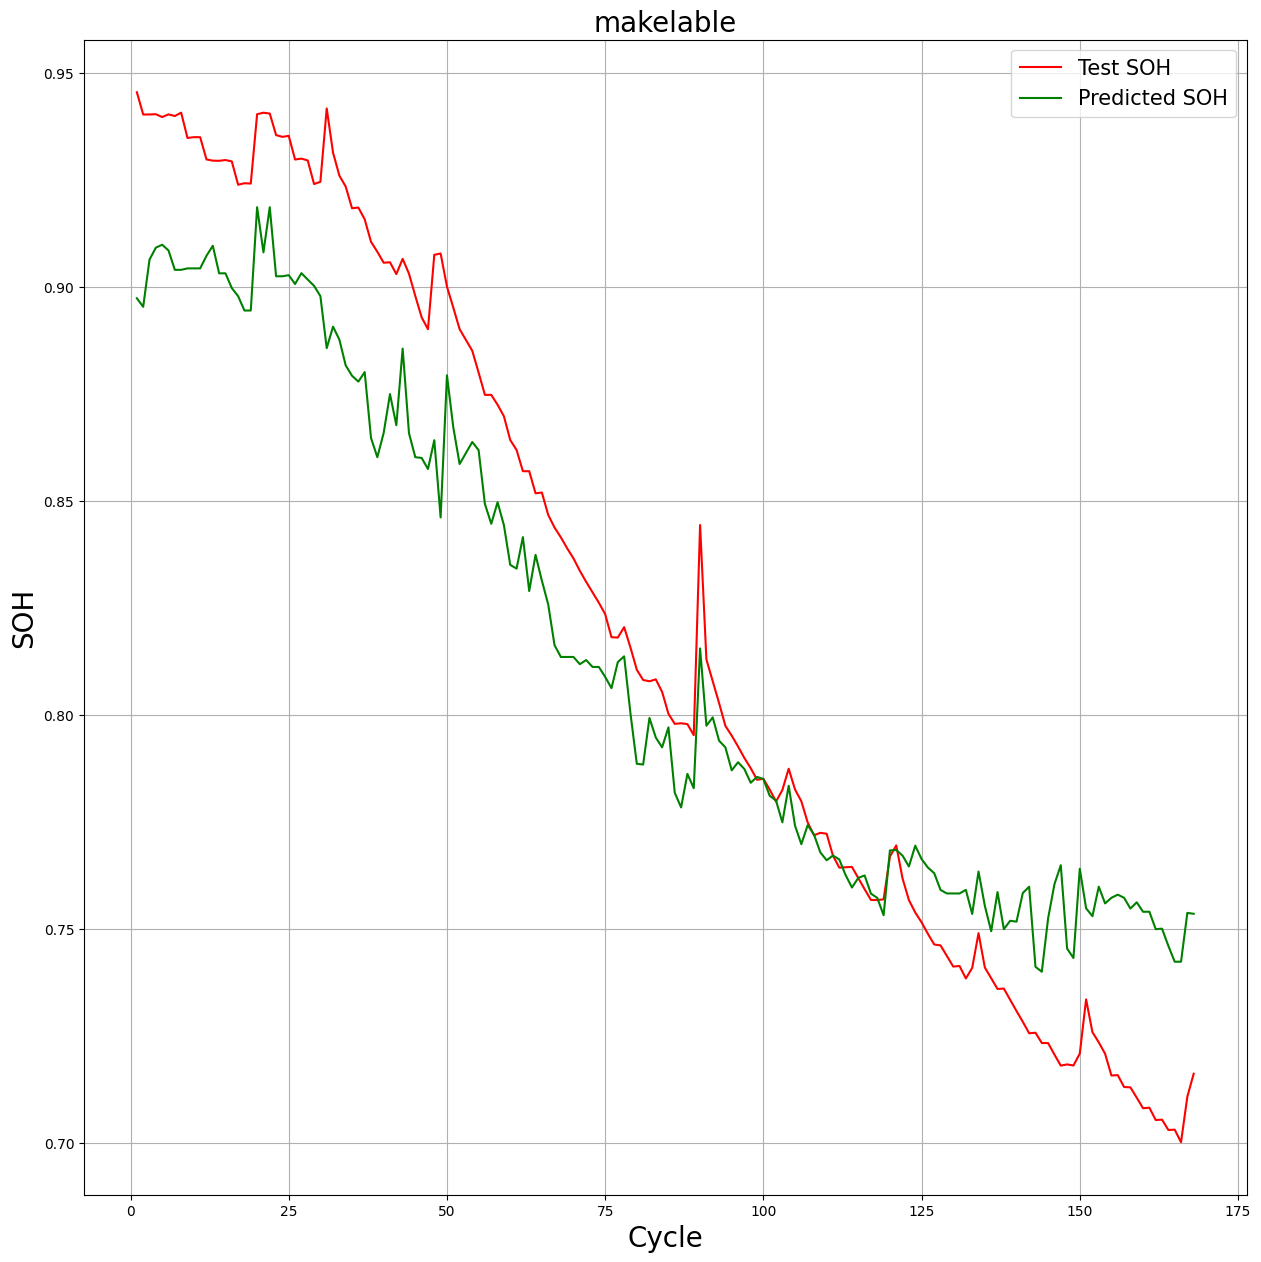

In [56]:
print(study_catboost_hype.best_params)
cat_hype = CatBoostRegressor(**study_catboost_hype.best_params)
cat_hype.fit(
    hype_train.detach().cpu().numpy(), y_train_np,
    eval_set=(hype_val.detach().cpu().numpy(), y_val_np),
    early_stopping_rounds=50,
    verbose=False
)
y_pred = cat_hype.predict(hype_test.detach().cpu().numpy())
results(y_test_np, y_pred)


In [ ]:
lstm_ica = LSTM_ica(hid_size=246,  num_layers=2, dropout=0.0746)

  0%|          | 0/1000 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([16, 1])) that is different to the input size (torch.Size([16])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 1000/1000 [06:31<00:00,  2.55it/s]


R2 score = 0.944956
rmse = 1.882430%
mae = 0.015731


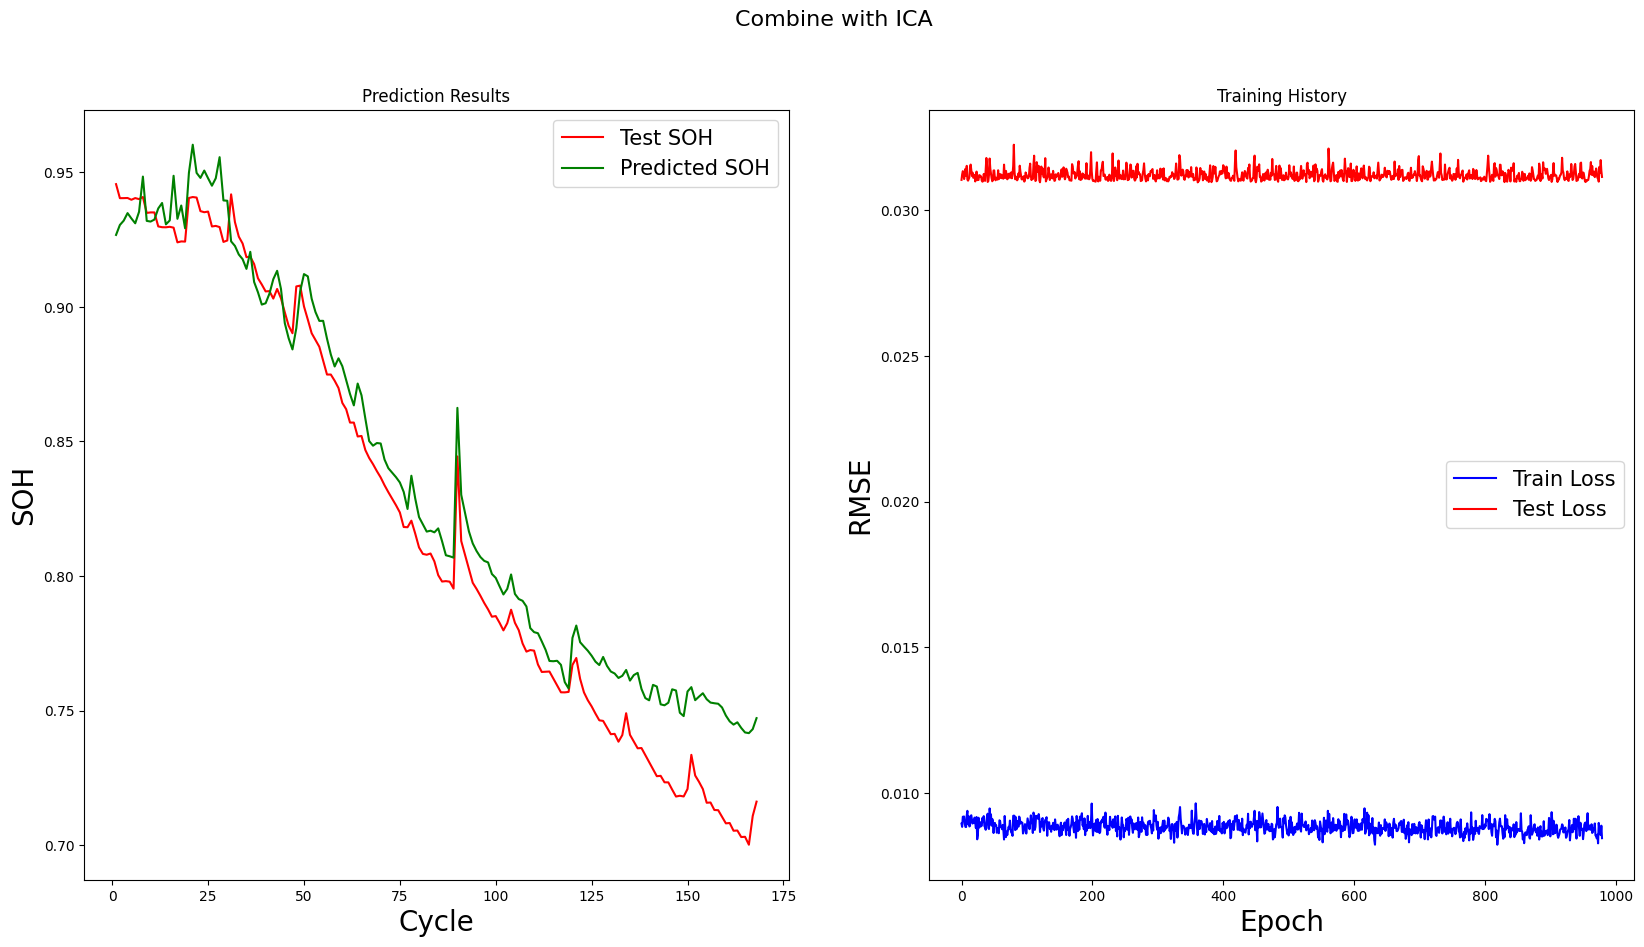

In [141]:
# new lstm architecture with ica features
test_model(lstm_ica, 1000, tr_dl=tr_dl_ica, val_dl=val_dl_ica, label='Combine with ICA', ica=True,
          optim=torch.optim.AdamW(lstm_ica.parameters(), lr=1e-6))

In [135]:
# GBT usage on features from LSTM combined with ica features
lstm_ica_train = np.concatenate([best_lstm(X_train_torch.to(device)).detach().cpu().numpy(),
                                 ica_train], 1)

lstm_ica_val = np.concatenate([best_lstm(X_val_torch.to(device)).detach().cpu().numpy(),
                                 ica_val], 1)

lstm_ica_test = np.concatenate([best_lstm(X_test_torch.to(device)).detach().cpu().numpy(),
                                 ica_test], 1)


study_ica_lstm = optuna.create_study(
    direction='minimize'
)

study_ica_lstm.optimize(lambda trial: objective_catboost(trial, 
                                                         lstm_ica_train, 
                                                         y_train_np,
                                                         lstm_ica_val, 
                                                         y_val_np), 
                        n_trials=30, show_progress_bar=True)



[I 2025-09-24 12:34:54,564] A new study created in memory with name: no-name-412d1541-9fdc-4a8e-9ab3-f7ffa23fadac


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2025-09-24 12:34:56,234] Trial 0 finished with value: 0.027158403978468196 and parameters: {'iterations': 1981, 'learning_rate': 0.02514705911129008, 'depth': 4, 'l2_leaf_reg': 6.230103436640318, 'random_strength': 2.37608676851535, 'bagging_temperature': 0.570819819231237, 'leaf_estimation_iterations': 5}. Best is trial 0 with value: 0.027158403978468196.
[I 2025-09-24 12:35:19,734] Trial 1 finished with value: 0.03586915335942659 and parameters: {'iterations': 1164, 'learning_rate': 0.022546094090809557, 'depth': 10, 'l2_leaf_reg': 8.367439308918154, 'random_strength': 0.12768344241137378, 'bagging_temperature': 0.1043032207143667, 'leaf_estimation_iterations': 15}. Best is trial 0 with value: 0.027158403978468196.
[I 2025-09-24 12:35:23,577] Trial 2 finished with value: 0.03376766661067004 and parameters: {'iterations': 897, 'learning_rate': 0.014651456416053834, 'depth': 4, 'l2_leaf_reg': 4.573459517587072, 'random_strength': 0.4934865253167878, 'bagging_temperature': 0.69261898

{'iterations': 1105, 'learning_rate': 0.04403408714883918, 'depth': 6, 'l2_leaf_reg': 1.6657039404883187, 'random_strength': 9.650563378544195, 'bagging_temperature': 0.40823766500109104, 'leaf_estimation_iterations': 7}
R2 score = 0.916294
rmse = 2.321373%
mae = 0.020979


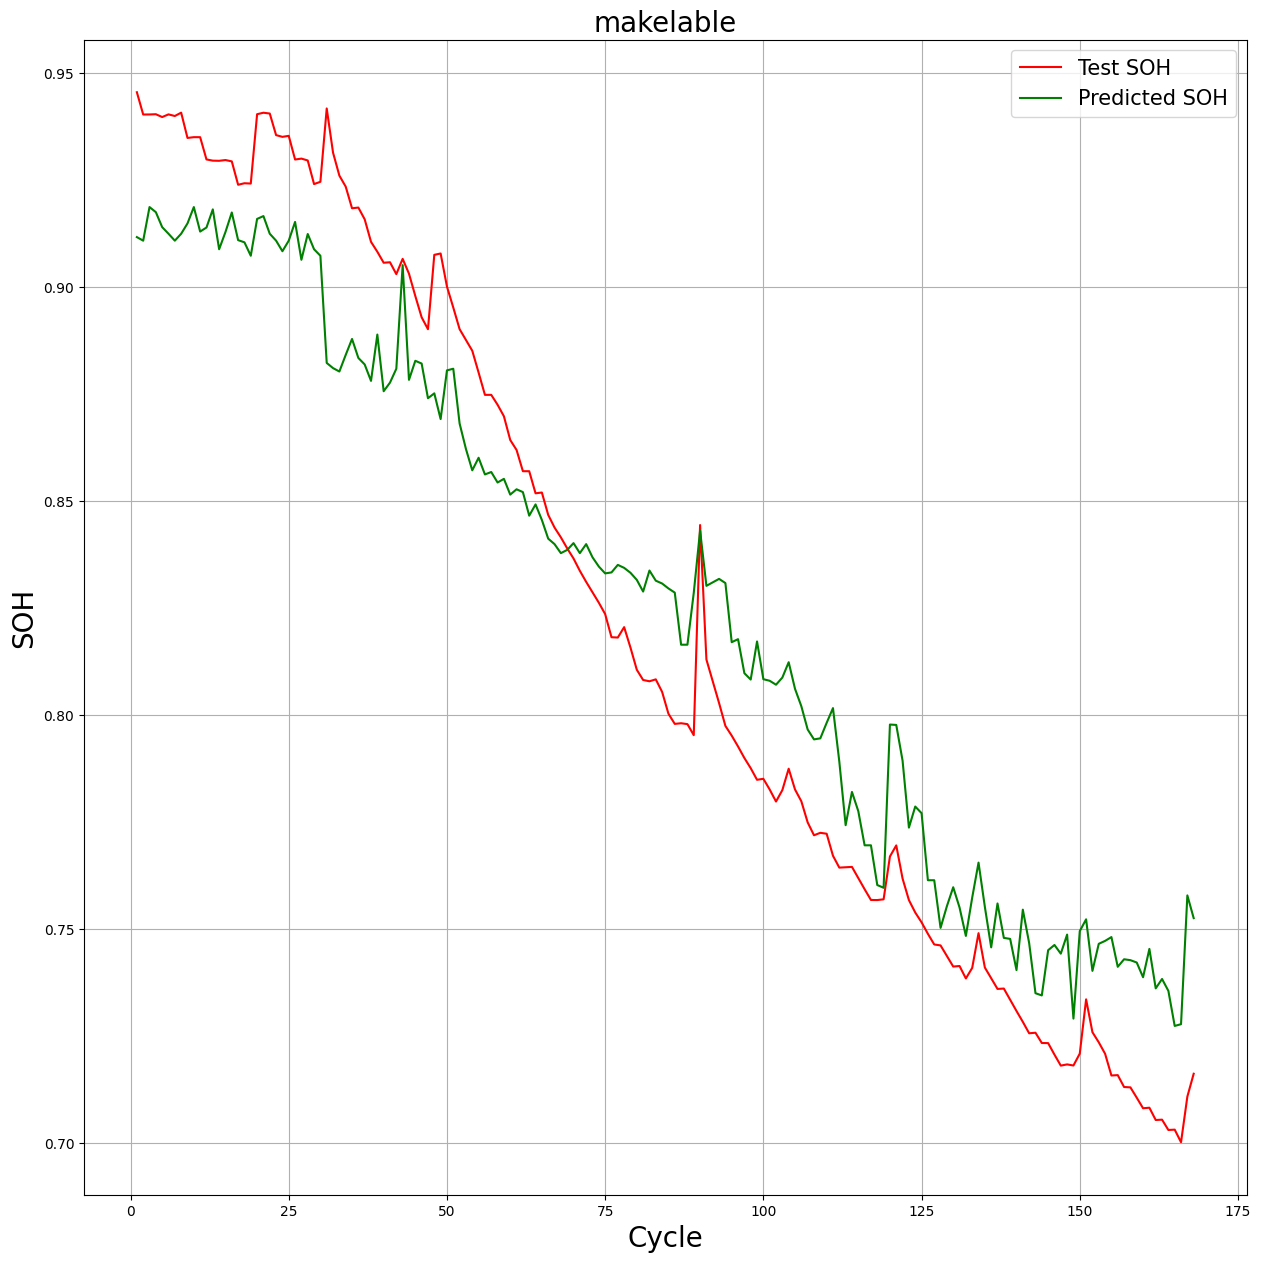

In [136]:
print(study_ica_lstm.best_params)
cat_hype = CatBoostRegressor(**study_ica_lstm.best_params)
cat_hype.fit(
    lstm_ica_train, y_train_np,
    eval_set=(lstm_ica_val, y_val_np),
    early_stopping_rounds=50,
    verbose=False
)
y_pred = cat_hype.predict(lstm_ica_test)
results(y_test_np, y_pred, label='ICA + lstm preds')
